# Analysis Notebook 

## setting up env and loading data 

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.12.12 |       h06a4308_0         126 KB
    certifi-2024.2.2           |  py310h06a4308_0         159 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 

Th

In [3]:
#https://openblocklabs-interview-datasets.s3.amazonaws.com/market_depth/ekubo_market_depth_dataset.parquet

In [4]:
!aws s3 cp s3://openblocklabs-interview-datasets/market_depth/ekubo_market_depth_dataset.parquet . --request-payer requester

download: s3://openblocklabs-interview-datasets/market_depth/ekubo_market_depth_dataset.parquet to ./ekubo_market_depth_dataset.parquet


In [5]:
import sagemaker
import subprocess

# Initialize SageMaker session and get the default bucket
sess = sagemaker.Session()
bucket = sess.default_bucket()

# Define the source S3 path and target S3 path
source_s3_path = "s3://openblocklabs-interview-datasets/market_depth/ekubo_market_depth_dataset.parquet"
target_s3_path = f"s3://{bucket}/openblocks/data/ekubo_market_depth_dataset.parquet"

# Construct the AWS CLI command for copying
aws_cli_command = f"aws s3 cp {source_s3_path} {target_s3_path} --request-payer requester"

# Execute the command
subprocess.run(aws_cli_command, shell=True, check=True)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
copy: s3://openblocklabs-interview-datasets/market_depth/ekubo_market_depth_dataset.parquet to s3://sagemaker-us-east-1-211125710179/openblocks/data/ekubo_market_depth_dataset.parquet


CompletedProcess(args='aws s3 cp s3://openblocklabs-interview-datasets/market_depth/ekubo_market_depth_dataset.parquet s3://sagemaker-us-east-1-211125710179/openblocks/data/ekubo_market_depth_dataset.parquet --request-payer requester', returncode=0)

In [6]:
import json
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline

In [7]:
# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3," "org.apache.hadoop:hadoop-aws:3.2.2")\
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )\
    .getOrCreate()


:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e6534569-c5b5-459b-9ccf-fd8fe0f64659;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

In [8]:
%%time

df = spark.read.parquet(f"s3a://{bucket}/openblocks/data/ekubo_market_depth_dataset.parquet")

24/03/13 05:32:02 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


CPU times: user 5.73 ms, sys: 4.58 ms, total: 10.3 ms
Wall time: 5.48 s


In [9]:
#Print the Schema
df.printSchema()

root
 |-- BLOCK_NUMBER: decimal(38,0) (nullable = true)
 |-- BLOCK_TIMESTAMP: timestamp (nullable = true)
 |-- TX_HASH: string (nullable = true)
 |-- TX_ID: string (nullable = true)
 |-- POOL_ID: string (nullable = true)
 |-- TOKEN0_ADDRESS: string (nullable = true)
 |-- TOKEN1_ADDRESS: string (nullable = true)
 |-- EVENT_NAME: string (nullable = true)
 |-- FROM_ADDRESS: string (nullable = true)
 |-- TO_ADDRESS: string (nullable = true)
 |-- TOKEN0_RAW_AMOUNT: decimal(38,0) (nullable = true)
 |-- TOKEN0_DECIMALS: decimal(2,0) (nullable = true)
 |-- TOKEN0_REAL_AMOUNT: decimal(38,30) (nullable = true)
 |-- TOKEN1_RAW_AMOUNT: decimal(38,0) (nullable = true)
 |-- TOKEN1_DECIMALS: decimal(2,0) (nullable = true)
 |-- TOKEN1_REAL_AMOUNT: decimal(38,30) (nullable = true)
 |-- FEE_TIER: float (nullable = true)
 |-- LIQUIDITY_AMOUNT: decimal(38,0) (nullable = true)
 |-- LOWER_TICK: decimal(38,0) (nullable = true)
 |-- UPPER_TICK: decimal(38,0) (nullable = true)
 |-- SWAP_TICK: decimal(38,0) (nu

In [10]:
%%time
num_rows = df.count()
num_columns = len(df.columns)
print(f"DataFrame shape: ({num_rows}, {num_columns})")

DataFrame shape: (3024741, 22)
CPU times: user 258 µs, sys: 2.68 ms, total: 2.94 ms
Wall time: 2.03 s


In [11]:
df.show(10)

+------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+-----------------+---------------+--------------------+-----------------+---------------+--------------------+--------+----------------+----------+----------+---------+------------+
|BLOCK_NUMBER|    BLOCK_TIMESTAMP|             TX_HASH|               TX_ID|             POOL_ID|      TOKEN0_ADDRESS|      TOKEN1_ADDRESS|EVENT_NAME|        FROM_ADDRESS|          TO_ADDRESS|TOKEN0_RAW_AMOUNT|TOKEN0_DECIMALS|  TOKEN0_REAL_AMOUNT|TOKEN1_RAW_AMOUNT|TOKEN1_DECIMALS|  TOKEN1_REAL_AMOUNT|FEE_TIER|LIQUIDITY_AMOUNT|LOWER_TICK|UPPER_TICK|SWAP_TICK|TICK_SPACING|
+------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+-----------------+---------------+--------------------+-----

## Ticks to price in ekubo protocol 

https://docs.ekubo.org/about-ekubo/key-concepts

- Ticks correspond to exact prices which can be used to specify boundaries for positions. Position boundaries are specified as ticks rather than arbitrary prices so the AMM can more efficiently process swaps. Ticks could be defined arbitrarily, but the most uniform way to break up the entire price range is in log-space.

- In Ekubo, the tick size is 1.000001, or 1/100th of a basis point. You can get the price by raising 1.000001 to the power tick. This level of precision is smaller than most centralized limit order books. In other words, that means you can create one-tick positions, similar to limit orders, at prices more specific than you could on centralized exchanges. This makes Ekubo a great place to build an on-chain order book.

In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def tick_to_price(tick):
    # Convert Decimal tick to float before performing the operation
    return 1.000001 ** float(tick)


# register UDF
tick_to_price_udf = udf(tick_to_price, DoubleType())

# apply UDF
df_with_prices = df.withColumn("price_low", tick_to_price_udf("LOWER_TICK"))\
                   .withColumn("price_high", tick_to_price_udf("UPPER_TICK"))

df_with_prices.select("LOWER_TICK", "UPPER_TICK", "price_low", "price_high").show()


+----------+----------+--------------------+--------------------+
|LOWER_TICK|UPPER_TICK|           price_low|          price_high|
+----------+----------+--------------------+--------------------+
|    -20000|     20000|  0.9801986831103483|  1.0202013298230708|
|    -20000|     20000|  0.9801986831103483|  1.0202013298230708|
| -20284000| -20244000|1.551583435245099...|1.614904724158150...|
| -20279000| -20239000|1.559360775680326...|1.622999463715774...|
|    -20000|     20000|  0.9801986831103483|  1.0202013298230708|
|    -20000|     20000|  0.9801986831103483|  1.0202013298230708|
| -20287000| -20247000|1.546935662408715E-9|1.610067272210807...|
| -20287000| -20247000|1.546935662408715E-9|1.610067272210807...|
| -20275000| -20235000|1.565610707187346...|1.629504459636125E-9|
| -20279000| -20243000|1.559360775680326...|1.616520435795496E-9|
| -29935000| -29934000|9.98622129012372E-14|9.996212501190351...|
| -20281000| -20241000|1.556245172328908...|1.619756710244375...|
| -2027400

## Data Cleaning 

In [18]:
from pyspark.sql.functions import col, when

# Filter out rows where the price is zero or negative
df_with_valid_prices = df_with_prices.filter((col("price_low") > 0) & (col("price_high") > 0))

# Check for extremely high or low values that could distort the chart
extreme_values = df_with_valid_prices.agg({"price_low": "max", "price_high": "max"}).collect()
min_values = df_with_valid_prices.agg({"price_low": "min", "price_high": "min"}).collect()

print("Extreme Values:", extreme_values)
print("Minimum Values:", min_values)

Extreme Values: [Row(max(price_high)=3.4028220345482378e+38, max(price_low)=3.388278921355584e+38)]
Minimum Values: [Row(min(price_high)=2.944276141515469e-39, min(price_low)=2.938737288777316e-39)]


In [19]:
upper_bound = 1e6 
lower_bound = 1e-6  

df_filtered = df_with_valid_prices.filter((col("price_low") > lower_bound) & (col("price_low") < upper_bound) &
                                          (col("price_high") > lower_bound) & (col("price_high") < upper_bound))


In [22]:
from pyspark.sql.functions import col, when

threshold = 1e9  # This is just an example threshold
df_capped = df_filtered.withColumn("capped_liquidity", 
                                   when(col("LIQUIDITY_AMOUNT") > threshold, threshold)\
                                   .otherwise(col("LIQUIDITY_AMOUNT")))


In [23]:
%%time
num_rows = df_capped.count()
num_columns = len(df_capped.columns)
print(f"DataFrame shape: ({num_rows}, {num_columns})")

DataFrame shape: (2666948, 25)
CPU times: user 8.94 ms, sys: 0 ns, total: 8.94 ms
Wall time: 10.2 s


After some data cleaning, the datasize went from (3024741, 22) to (2666948, 25) 

## Creating STRK/ETH, STRK/USDC, ETH/USDC Pools 

In [27]:
from pyspark.sql.functions import col
address_counts = df_capped.groupBy("TOKEN0_ADDRESS").count()
top_10_addresses = address_counts.orderBy(col("count").desc())
top_10_addresses.take(5)

[Row(TOKEN0_ADDRESS='0x049d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7', count=1634145),
 Row(TOKEN0_ADDRESS='0x053c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8', count=809605),
 Row(TOKEN0_ADDRESS='0x04718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d', count=223198)]

address:  
- eth: `0x049d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc` 
- USDC: `0x053c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8`
- STRK: `0x04718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d`

In [31]:
eth_address = "0x049d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7"
strk_address = "0x04718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d"
usdc_address = "0x053c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8"

In [32]:
strk_eth_pool = df_capped.filter(
    ((F.col('TOKEN0_ADDRESS') == strk_address) & (F.col('TOKEN1_ADDRESS') == eth_address)) |
    (F.col('TOKEN0_ADDRESS') == eth_address) & (F.col('TOKEN1_ADDRESS') == strk_address)
)
strk_eth_pool.take(5)

[Row(BLOCK_NUMBER=Decimal('536785'), BLOCK_TIMESTAMP=datetime.datetime(2024, 2, 8, 22, 46, 45), TX_HASH='0x05653fdfe2ee52befbed76d298173c2a4cc6ee894b68f0a1070aafdb8efa215e', TX_ID='5461067_0_536785_34', POOL_ID='0x00000005dd3d2f4429af886cd1a3b08289dbcea99a294197e9eb43b0e0325b4b-0x04718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d-0x049d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7-34028236692093847977029636859101184-200', TOKEN0_ADDRESS='0x04718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d', TOKEN1_ADDRESS='0x049d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7', EVENT_NAME='Mint', FROM_ADDRESS='0x02b86094d3a7c4e642577798c000827ff1d664c75bd3d9728786cdb600670117', TO_ADDRESS='0x00000005dd3d2f4429af886cd1a3b08289dbcea99a294197e9eb43b0e0325b4b', TOKEN0_RAW_AMOUNT=Decimal('0'), TOKEN0_DECIMALS=Decimal('18'), TOKEN0_REAL_AMOUNT=Decimal('0E-30'), TOKEN1_RAW_AMOUNT=Decimal('-99999999999999983'), TOKEN1_DECIMALS=Decimal('18'), TOKEN1_REAL_

In [33]:
strk_usdc_pool = df_capped.filter(
    ((F.col('TOKEN0_ADDRESS') == strk_address) & (F.col('TOKEN1_ADDRESS') == usdc_address)) |
    (F.col('TOKEN0_ADDRESS') == usdc_address) & (F.col('TOKEN1_ADDRESS') == strk_address)
)
strk_usdc_pool.take(5)

[Row(BLOCK_NUMBER=Decimal('567360'), BLOCK_TIMESTAMP=datetime.datetime(2024, 2, 22, 2, 38, 32), TX_HASH='0x07cb0d586fd5375510ea07e7a58f09e3107f7f92c6502b990bf161c3ed818008', TX_ID='5461067_0_567360_4', POOL_ID='0x00000005dd3d2f4429af886cd1a3b08289dbcea99a294197e9eb43b0e0325b4b-0x04718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d-0x053c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8-17014118346046923173168730371588410572-95310', TOKEN0_ADDRESS='0x04718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d', TOKEN1_ADDRESS='0x053c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8', EVENT_NAME='Mint', FROM_ADDRESS='0x0395211ec88e0a6ad6be1a84f3d3d330dd1cb9b2057e77ed036548909e49c09e', TO_ADDRESS='0x00000005dd3d2f4429af886cd1a3b08289dbcea99a294197e9eb43b0e0325b4b', TOKEN0_RAW_AMOUNT=Decimal('-89999999'), TOKEN0_DECIMALS=Decimal('18'), TOKEN0_REAL_AMOUNT=Decimal('-8.9999999000000005287E-11'), TOKEN1_RAW_AMOUNT=Decimal('-89999999'), TOKEN1_DECIMALS=Dec

In [36]:
eth_usdc_pool = df_capped.filter(
    ((F.col('TOKEN0_ADDRESS') == eth_address) & (F.col('TOKEN1_ADDRESS') == usdc_address)) |
    (F.col('TOKEN0_ADDRESS') == usdc_address) & (F.col('TOKEN1_ADDRESS') == eth_address)
)
eth_usdc_pool.take(5)

[Row(BLOCK_NUMBER=Decimal('351649'), BLOCK_TIMESTAMP=datetime.datetime(2023, 10, 26, 5, 32, 59), TX_HASH='0x010294365cb23752815ae454effa44400fc8834c460978db25a35838a1fc128b', TX_ID='5461067_0_351649_123', POOL_ID='0x00000005dd3d2f4429af886cd1a3b08289dbcea99a294197e9eb43b0e0325b4b-0x049d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7-0x053c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8-170141183460469235273462165868118016-1000', TOKEN0_ADDRESS='0x049d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7', TOKEN1_ADDRESS='0x053c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8', EVENT_NAME='Mint', FROM_ADDRESS='0x058211a84d40a17b5b4fbc4cfbf95e622bad1fac17cdd055680504db12d2e1ed', TO_ADDRESS='0x00000005dd3d2f4429af886cd1a3b08289dbcea99a294197e9eb43b0e0325b4b', TOKEN0_RAW_AMOUNT=Decimal('-10000000000000'), TOKEN0_DECIMALS=Decimal('18'), TOKEN0_REAL_AMOUNT=Decimal('-0.000010000000000000000818030539'), TOKEN1_RAW_AMOUNT=Decimal('0'), TOKEN1_DECIMAL

In [37]:
buy_transactions_count = eth_usdc_pool.filter(F.col('EVENT_NAME') == 'Mint').count()
sell_transactions_count = eth_usdc_pool.filter(F.col('EVENT_NAME') == 'Burn').count()
print(f"buy transactions count in eth/usdc pool: {buy_transactions_count}")
print(f"sell transactions count in eth/usdc pool: {sell_transactions_count}")

buy transactions count in eth/usdc pool: 39
sell transactions count in eth/usdc pool: 6


In [38]:
buy_transactions_count = strk_eth_pool.filter(F.col('EVENT_NAME') == 'Mint').count()
sell_transactions_count = strk_eth_pool.filter(F.col('EVENT_NAME') == 'Burn').count()
print(f"buy transactions count in strk/eth pool: {buy_transactions_count}")
print(f"sell transactions count in strk/eth pool: {sell_transactions_count}")

buy transactions count in strk/eth pool: 17347
sell transactions count in strk/eth pool: 4476


In [39]:
buy_transactions_count = strk_eth_pool.filter(F.col('EVENT_NAME') == 'Mint').count()
sell_transactions_count = strk_eth_pool.filter(F.col('EVENT_NAME') == 'Burn').count()
print(f"buy transactions count in strk/eth pool: {buy_transactions_count}")
print(f"sell transactions count in strk/eth pool: {sell_transactions_count}")

buy transactions count in strk/eth pool: 17347
sell transactions count in strk/eth pool: 4476


## Calculate the cumulative liquidity for each pool  

In [40]:
from pyspark.sql.functions import col

strk_usdc_pool_with_prices = strk_usdc_pool.withColumn("price_low", tick_to_price_udf("LOWER_TICK"))\
                   .withColumn("price_high", tick_to_price_udf("UPPER_TICK"))

strk_usdc_pool_sorted = strk_usdc_pool_with_prices.orderBy(col('price_low'))
strk_usdc_pool_sorted.show(5)

+------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+---------------+--------------------+-----------------+---------------+--------------------+--------+----------------+----------+----------+---------+------------+------------------+------------------+----------------+
|BLOCK_NUMBER|    BLOCK_TIMESTAMP|             TX_HASH|              TX_ID|             POOL_ID|      TOKEN0_ADDRESS|      TOKEN1_ADDRESS|EVENT_NAME|        FROM_ADDRESS|          TO_ADDRESS|   TOKEN0_RAW_AMOUNT|TOKEN0_DECIMALS|  TOKEN0_REAL_AMOUNT|TOKEN1_RAW_AMOUNT|TOKEN1_DECIMALS|  TOKEN1_REAL_AMOUNT|FEE_TIER|LIQUIDITY_AMOUNT|LOWER_TICK|UPPER_TICK|SWAP_TICK|TICK_SPACING|         price_low|        price_high|capped_liquidity|
+------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+

In [41]:
from pyspark.sql import Window
from pyspark.sql.functions import col, sum as _sum

# Assuming you have a Spark DataFrame `df` with the columns `price_low`, `price_high`, and `LIQUIDITY_AMOUNT`

# Calculate cumulative liquidity for price_low (buy orders)
windowSpecBuy = Window.orderBy(col('price_low')).rowsBetween(Window.unboundedPreceding, Window.currentRow)
strk_usdc_pool_sorted = strk_usdc_pool_sorted.withColumn('Cumulative_Liquidity_Buy', _sum('LIQUIDITY_AMOUNT').over(windowSpecBuy))

# Calculate cumulative liquidity for price_high (sell orders)
windowSpecSell = Window.orderBy(col('price_high').desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
strk_usdc_pool_sorted = strk_usdc_pool_sorted.withColumn('Cumulative_Liquidity_Sell', _sum('LIQUIDITY_AMOUNT').over(windowSpecSell))

# Now you have two new columns: `Cumulative_Liquidity_Buy` and `Cumulative_Liquidity_Sell`
# Next, you'd collect the data to your local environment
buy_orders = strk_usdc_pool_sorted.select('price_low', 'Cumulative_Liquidity_Buy').sort('price_low').toPandas()
sell_orders = strk_usdc_pool_sorted.select('price_high', 'Cumulative_Liquidity_Sell').sort('price_high', ascending=False).toPandas()


24/03/13 05:42:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/03/13 05:42:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/03/13 05:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/03/13 05:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/03/13 05:42:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/03/13 05:42:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/03/13 0

## Market Depth Analysis:
- Calculate market depth for the Ekubo Protocol for STRK/ETH, STRK/USDC, ETH/USDC, USDC/USDT pools.

In [42]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def tick_to_price(tick):
    # Convert Decimal tick to float before performing the operation
    return 1.000001 ** float(tick)


# register UDF
tick_to_price_udf = udf(tick_to_price, DoubleType())

# apply UDF
df_with_prices = df.withColumn("price_low", tick_to_price_udf("LOWER_TICK"))\
                   .withColumn("price_high", tick_to_price_udf("UPPER_TICK"))

df_with_prices.select("LOWER_TICK", "UPPER_TICK", "price_low", "price_high").show()


+----------+----------+--------------------+--------------------+
|LOWER_TICK|UPPER_TICK|           price_low|          price_high|
+----------+----------+--------------------+--------------------+
|    -20000|     20000|  0.9801986831103483|  1.0202013298230708|
|    -20000|     20000|  0.9801986831103483|  1.0202013298230708|
| -20284000| -20244000|1.551583435245099...|1.614904724158150...|
| -20279000| -20239000|1.559360775680326...|1.622999463715774...|
|    -20000|     20000|  0.9801986831103483|  1.0202013298230708|
|    -20000|     20000|  0.9801986831103483|  1.0202013298230708|
| -20287000| -20247000|1.546935662408715E-9|1.610067272210807...|
| -20287000| -20247000|1.546935662408715E-9|1.610067272210807...|
| -20275000| -20235000|1.565610707187346...|1.629504459636125E-9|
| -20279000| -20243000|1.559360775680326...|1.616520435795496E-9|
| -29935000| -29934000|9.98622129012372E-14|9.996212501190351...|
| -20281000| -20241000|1.556245172328908...|1.619756710244375...|
| -2027400

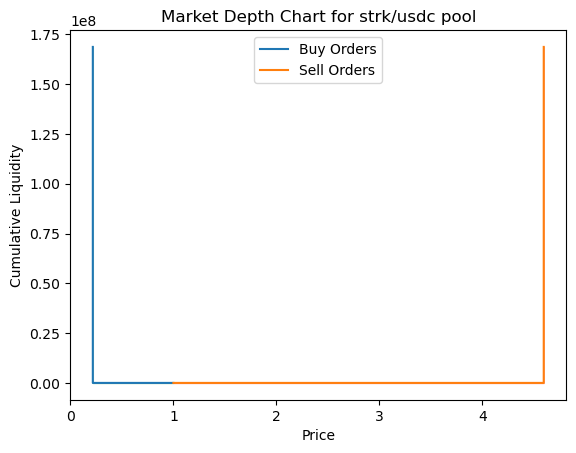

In [43]:
import matplotlib.pyplot as plt

# Plot buy orders
plt.plot(buy_orders['price_low'], buy_orders['Cumulative_Liquidity_Buy'], label='Buy Orders')

# Plot sell orders
plt.plot(sell_orders['price_high'], sell_orders['Cumulative_Liquidity_Sell'], label='Sell Orders')

plt.fill_between(buy_orders['price_low'], 0, buy_orders['Cumulative_Liquidity_Buy'], color='green', alpha=0.3)
plt.fill_between(sell_orders['price_high'], 0, sell_orders['Cumulative_Liquidity_Sell'], color='red', alpha=0.3)

# Labels and Legend
plt.xlabel('Price')
plt.ylabel('Cumulative Liquidity')
plt.title('Market Depth Chart for strk/usdc pool')
plt.legend()

# Display the plot
plt.show()

In [44]:
eth_usdc_pool_with_prices = eth_usdc_pool.withColumn("price_low", tick_to_price_udf("LOWER_TICK"))\
                                         .withColumn("price_high", tick_to_price_udf("UPPER_TICK"))

strk_eth_pool_with_prices = strk_eth_pool.withColumn("price_low", tick_to_price_udf("LOWER_TICK"))\
                                         .withColumn("price_high", tick_to_price_udf("UPPER_TICK"))


In [45]:
# Create window specifications for cumulative liquidity calculations
windowSpecBuy = Window.orderBy(col('price_low')).rowsBetween(Window.unboundedPreceding, Window.currentRow)
windowSpecSell = Window.orderBy(col('price_high').desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)


In [46]:
# Calculate cumulative liquidity for buy and sell orders in each pool
eth_usdc_pool_sorted = eth_usdc_pool_with_prices.withColumn('Cumulative_Liquidity_Buy', _sum('LIQUIDITY_AMOUNT').over(windowSpecBuy))\
                                                .withColumn('Cumulative_Liquidity_Sell', _sum('LIQUIDITY_AMOUNT').over(windowSpecSell))

strk_eth_pool_sorted = strk_eth_pool_with_prices.withColumn('Cumulative_Liquidity_Buy', _sum('LIQUIDITY_AMOUNT').over(windowSpecBuy))\
                                                .withColumn('Cumulative_Liquidity_Sell', _sum('LIQUIDITY_AMOUNT').over(windowSpecSell))


In [54]:
strk_eth_pool_sorted

DataFrame[BLOCK_NUMBER: decimal(38,0), BLOCK_TIMESTAMP: timestamp, TX_HASH: string, TX_ID: string, POOL_ID: string, TOKEN0_ADDRESS: string, TOKEN1_ADDRESS: string, EVENT_NAME: string, FROM_ADDRESS: string, TO_ADDRESS: string, TOKEN0_RAW_AMOUNT: decimal(38,0), TOKEN0_DECIMALS: decimal(2,0), TOKEN0_REAL_AMOUNT: decimal(38,30), TOKEN1_RAW_AMOUNT: decimal(38,0), TOKEN1_DECIMALS: decimal(2,0), TOKEN1_REAL_AMOUNT: decimal(38,30), FEE_TIER: float, LIQUIDITY_AMOUNT: decimal(38,0), LOWER_TICK: decimal(38,0), UPPER_TICK: decimal(38,0), SWAP_TICK: decimal(38,0), TICK_SPACING: decimal(38,0), price_low: double, price_high: double, capped_liquidity: double, Cumulative_Liquidity_Buy: decimal(38,0), Cumulative_Liquidity_Sell: decimal(38,0)]

In [55]:
eth_usdc_pool_sorted

DataFrame[BLOCK_NUMBER: decimal(38,0), BLOCK_TIMESTAMP: timestamp, TX_HASH: string, TX_ID: string, POOL_ID: string, TOKEN0_ADDRESS: string, TOKEN1_ADDRESS: string, EVENT_NAME: string, FROM_ADDRESS: string, TO_ADDRESS: string, TOKEN0_RAW_AMOUNT: decimal(38,0), TOKEN0_DECIMALS: decimal(2,0), TOKEN0_REAL_AMOUNT: decimal(38,30), TOKEN1_RAW_AMOUNT: decimal(38,0), TOKEN1_DECIMALS: decimal(2,0), TOKEN1_REAL_AMOUNT: decimal(38,30), FEE_TIER: float, LIQUIDITY_AMOUNT: decimal(38,0), LOWER_TICK: decimal(38,0), UPPER_TICK: decimal(38,0), SWAP_TICK: decimal(38,0), TICK_SPACING: decimal(38,0), price_low: double, price_high: double, capped_liquidity: double, Cumulative_Liquidity_Buy: decimal(38,0), Cumulative_Liquidity_Sell: decimal(38,0)]

In [47]:
# Collect data for plotting
eth_usdc_buy_orders = eth_usdc_pool_sorted.select('price_low', 'Cumulative_Liquidity_Buy').sort('price_low').toPandas()
eth_usdc_sell_orders = eth_usdc_pool_sorted.select('price_high', 'Cumulative_Liquidity_Sell').sort('price_high', ascending=False).toPandas()

strk_eth_buy_orders = strk_eth_pool_sorted.select('price_low', 'Cumulative_Liquidity_Buy').sort('price_low').toPandas()
strk_eth_sell_orders = strk_eth_pool_sorted.select('price_high', 'Cumulative_Liquidity_Sell').sort('price_high', ascending=False).toPandas()


24/03/13 05:42:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/03/13 05:42:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/03/13 05:42:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/03/13 05:42:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/03/13 05:42:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/03/13 05:42:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/03/13 0

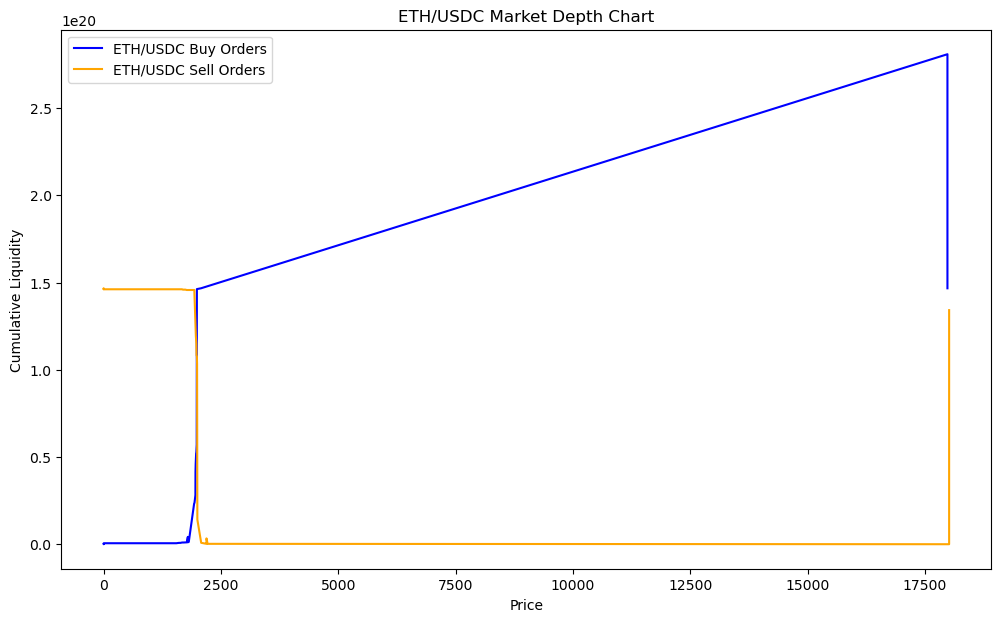

In [48]:
# Plot for ETH/USDC
plt.figure(figsize=(12, 7))
plt.plot(eth_usdc_buy_orders['price_low'], eth_usdc_buy_orders['Cumulative_Liquidity_Buy'], label='ETH/USDC Buy Orders', color='blue')
plt.plot(eth_usdc_sell_orders['price_high'], eth_usdc_sell_orders['Cumulative_Liquidity_Sell'], label='ETH/USDC Sell Orders', color='orange')
plt.xlabel('Price')
plt.ylabel('Cumulative Liquidity')
plt.title('ETH/USDC Market Depth Chart')
plt.legend()
plt.show()

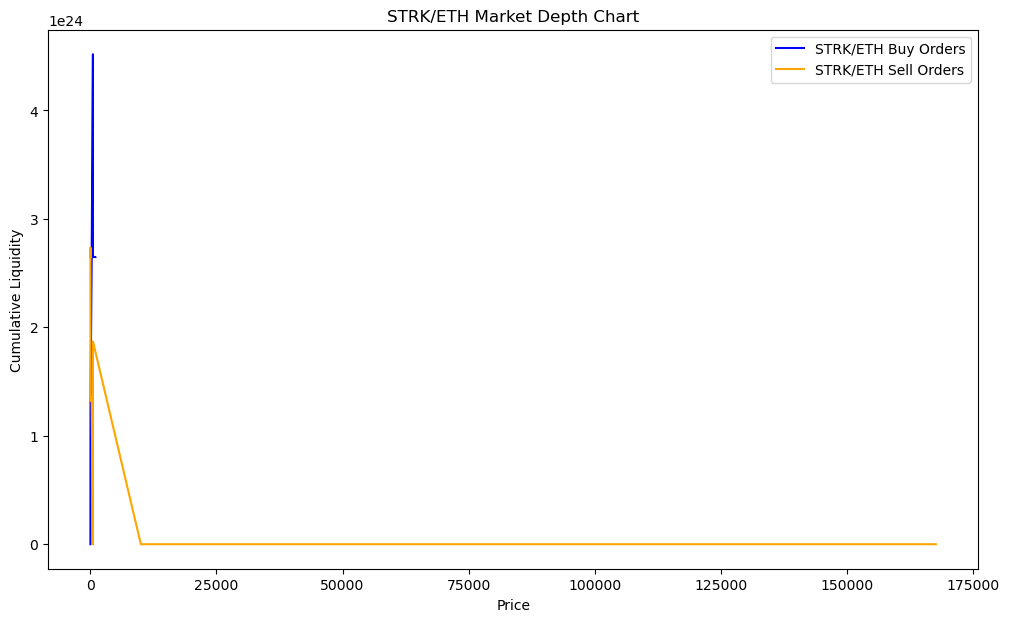

In [49]:
# Plot for STRK/ETH
plt.figure(figsize=(12, 7))
plt.plot(strk_eth_buy_orders['price_low'], strk_eth_buy_orders['Cumulative_Liquidity_Buy'], label='STRK/ETH Buy Orders', color='blue')
plt.plot(strk_eth_sell_orders['price_high'], strk_eth_sell_orders['Cumulative_Liquidity_Sell'], label='STRK/ETH Sell Orders', color='orange')
plt.xlabel('Price')
plt.ylabel('Cumulative Liquidity')
plt.title('STRK/ETH Market Depth Chart')
plt.legend()
plt.show()


In [50]:
eth_usdc_buy_orders_filtered = eth_usdc_buy_orders[(eth_usdc_buy_orders['price_low'] >= 1000) & (eth_usdc_buy_orders['price_low'] <= 3000)]
eth_usdc_sell_orders_filtered = eth_usdc_sell_orders[(eth_usdc_sell_orders['price_high'] >= 1000) & (eth_usdc_sell_orders['price_high'] <= 3000)]

strk_eth_buy_orders_filtered = strk_eth_buy_orders[strk_eth_buy_orders['price_low'] <= 10000]
strk_eth_sell_orders_filtered = strk_eth_sell_orders[strk_eth_sell_orders['price_high'] <= 10000]


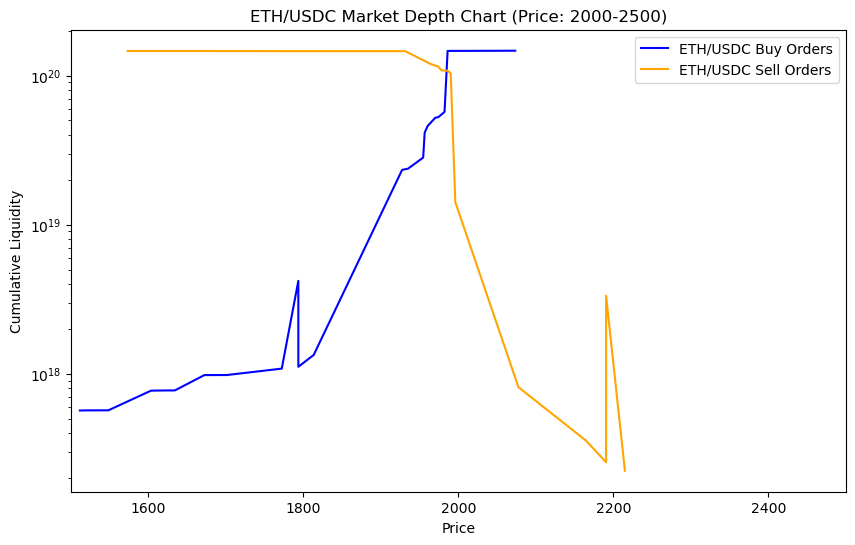

In [51]:
# Plot for ETH/USDC
plt.figure(figsize=(10, 6))
plt.plot(eth_usdc_buy_orders_filtered['price_low'], eth_usdc_buy_orders_filtered['Cumulative_Liquidity_Buy'], label='ETH/USDC Buy Orders', color='blue')
plt.plot(eth_usdc_sell_orders_filtered['price_high'], eth_usdc_sell_orders_filtered['Cumulative_Liquidity_Sell'], label='ETH/USDC Sell Orders', color='orange')

# Labels and Legend
plt.xlabel('Price')
plt.ylabel('Cumulative Liquidity')
plt.title('ETH/USDC Market Depth Chart (Price: 2000-2500)')
plt.legend()
plt.xlim(1500, 2500)  # Limit x-axis to 2000-2500 price range
plt.yscale('log')     # Optional: Use logarithmic scale for y-axis if needed
plt.show()

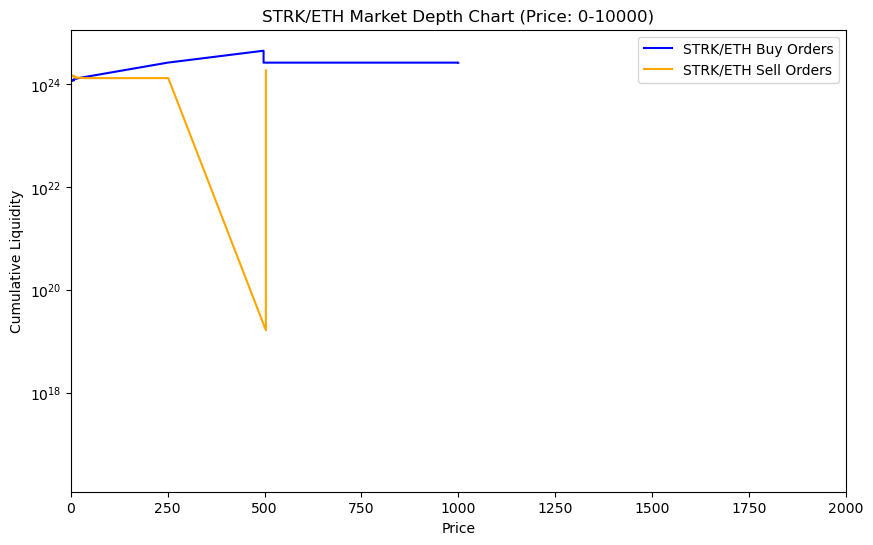

In [52]:
# Plot for STRK/ETH
plt.figure(figsize=(10, 6))
plt.plot(strk_eth_buy_orders_filtered['price_low'], strk_eth_buy_orders_filtered['Cumulative_Liquidity_Buy'], label='STRK/ETH Buy Orders', color='blue')
plt.plot(strk_eth_sell_orders_filtered['price_high'], strk_eth_sell_orders_filtered['Cumulative_Liquidity_Sell'], label='STRK/ETH Sell Orders', color='orange')

# Labels and Legend
plt.xlabel('Price')
plt.ylabel('Cumulative Liquidity')
plt.title('STRK/ETH Market Depth Chart (Price: 0-10000)')
plt.legend()
plt.xlim(0, 2000)    # Limit x-axis to 0-10000 price range
plt.yscale('log')     # Optional: Use logarithmic scale for y-axis if needed
plt.show()


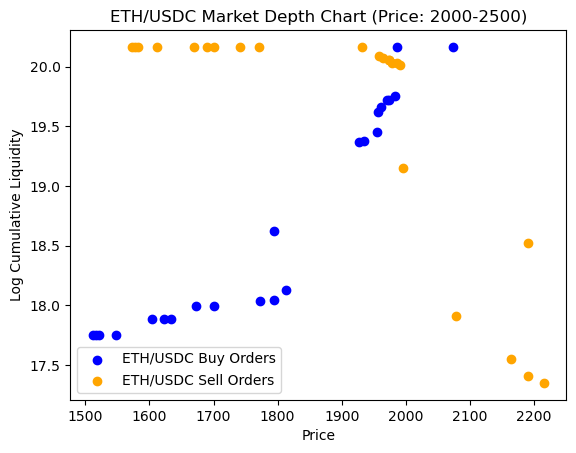

In [53]:
# Create scatter plots
plt.scatter(eth_usdc_buy_orders_filtered['price_low'], np.log10(eth_usdc_buy_orders_filtered['Cumulative_Liquidity_Buy']), color='blue', label='ETH/USDC Buy Orders')
plt.scatter(eth_usdc_sell_orders_filtered['price_high'], np.log10(eth_usdc_sell_orders_filtered['Cumulative_Liquidity_Sell']), color='orange', label='ETH/USDC Sell Orders')

# Labels and legend
plt.xlabel('Price')
plt.ylabel('Log Cumulative Liquidity')
plt.title('ETH/USDC Market Depth Chart (Price: 2000-2500)')
plt.legend()

# Show the plot
plt.show()

## Profit and Loss (PnL) Calculations:

- From the event data, calculate the PnL for a set of hypothetical positions of the most profitable LPs. Detail your approach and the outcomes of these calculations.
